In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns
from sequencing_tools.viz_tools import okabeito_palette, color_encoder, simpsons_palette
from sequencing_tools.stats_tools import p_adjust
from scipy.special import ndtr
from collections import defaultdict
from sequencing_tools.fastq_tools import reverse_complement
from sequencing_tools.bam_tools import get_strand
import RNA
from multiprocessing import Pool
import mygene 
import random
import pysam
import glob
import re
#import genomeview
from pybedtools import BedTool, set_tempdir
import mappy as mp
from plotting_utils import figure_path
from matplotlib import rcParams
from peak_utils import *
from tblout_parser import read_tbl
import sys
sys.path.insert(0,'/stor/home/cdw2854/cfNA/peak_callings')
from structural_peaks import PeakAnalyzer, mRNAFilter
from exon_coverage import ExonFilter
plt.rc('axes', labelsize=20)
plt.rc('xtick', labelsize = 20)
plt.rc('ytick', labelsize = 20)
plt.rc('font', **{'family':'sans-serif',
                  'sans-serif':'Arial'})
Peak_analyzer = PeakAnalyzer()
mrna_filter = mRNAFilter()
exon_filter = ExonFilter()

In [2]:
project_path = '/stor/work/Lambowitz/cdw2854/cfNA/tgirt_map'
set_tempdir(project_path)
peak_path = project_path + '/bed_files/merged_bed/MACS2/annotated'
#peak_path = project_path + '/CLAM//BED_files/peaks/annotation'
peak_tsv = peak_path + '/unfragmented.filtered.tsv'
print(peak_tsv)
peak_df = load_peaks(peak_tsv)  \
    .assign(sense_gtype = lambda d: np.where(d.sense_gtype == ".", 'Unannotated', d.sense_gtype))\
    .assign(antisense_gtype = lambda d: np.where(d.antisense_gtype == ".", 'Unannotated', d.antisense_gtype)) \
    .sort_values('pileup', ascending=False)   
peak_df.head()

/stor/work/Lambowitz/cdw2854/cfNA/tgirt_map/bed_files/merged_bed/MACS2/annotated/unfragmented.filtered.tsv


,chrom,start,end,peakname,score,fc,log10p,log10q,pileup,sample_count,sense_gname,sense_gtype,strand,antisense_gname,antisense_gtype,pvalue,FDR,is_sense
0,chr6,95156837,95156909,unfragmented.filtered.rvs_peak_23906,49831,1220.90051,4990.91406,4983.12256,1431.0,15.0,MTPAP,RBP,-,.,Unannotated,0.0,0.0,Sense
46879,chr16,223129,223709,unfragmented.filtered.rvs_peak_9743,22681,578.83380,2275.43311,2268.13550,778.0,15.0,.,Unannotated,-,HBA2,Long RNA,0.0,0.0,Antisense
46881,chr16,230338,230855,unfragmented.filtered.rvs_peak_9746,19008,478.68494,1907.96387,1900.81958,690.0,12.0,.,Unannotated,-,HBQ1,Long RNA,0.0,0.0,Antisense
46880,chr16,227335,227447,unfragmented.filtered.rvs_peak_9745,19796,526.54181,1986.90723,1979.65967,672.0,12.0,.,Unannotated,-,YBX3,RBP,0.0,0.0,Antisense
1,chr11,65273309,65273587,unfragmented.filtered.fwd_peak_5248,22296,532.33142,2237.13916,2229.68994,539.0,15.0,GTF2F1,RBP,+,TALAM1,Long RNA,0.0,0.0,Sense


In [3]:
peak_tsv

'/stor/work/Lambowitz/cdw2854/cfNA/tgirt_map/bed_files/merged_bed/MACS2/annotated/unfragmented.filtered.tsv'

/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/stor/home/cdw2854/cfNA/plots/peak_utils.py:560: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_xlim(0, 1e4)


Plotted:  /stor/work/Lambowitz/cdw2854/cfNA/tgirt_map/figure/peak_qc.pdf


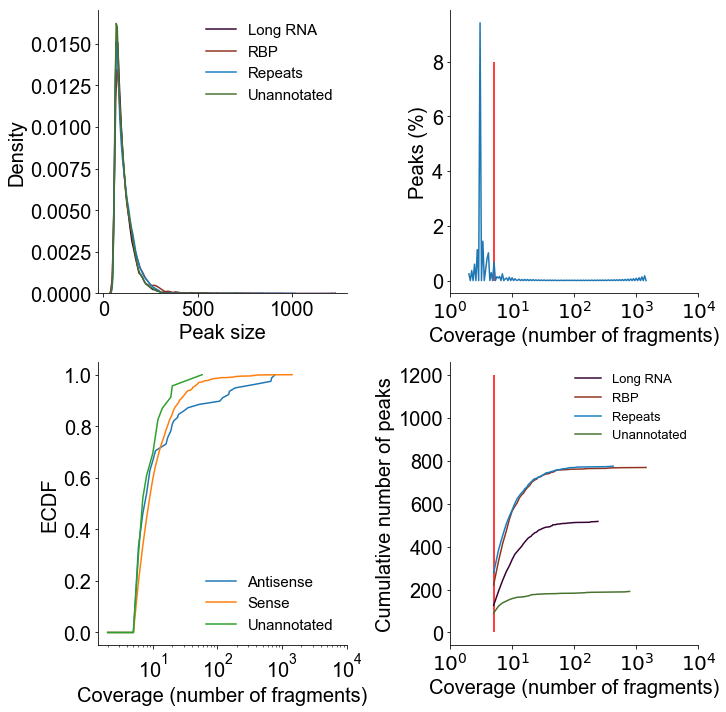

In [4]:
fig = plt.figure(figsize=(10,10))
size_ax = fig.add_subplot(221)
cov_ax = fig.add_subplot(222)
number_ax = fig.add_subplot(224)
dist_cov_ax = fig.add_subplot(223)
#peak_annotation_ax = fig.add_subplot(224)

plot_peak_size(peak_df, ax = size_ax)
size_ax.legend(fontsize=15, frameon=False)
plot_peak_coverage(peak_df, cov_ax, log=True)
#plot_cov_density(peak_df, dist_cov_ax)
plot_peak_cum_cov(peak_df, dist_cov_ax)
plot_peak_number(peak_df, number_ax, ce)
#### add hepG2
#combined_peaks = pd.concat([peak_df.assign(annotation = 'K562'),
#                        hep_peak_df.assign(annotation = 'K562 + HepG2')])
#plot_peak_bar(peak_annotation_ax, combined_peaks)
fig.tight_layout()

figurename = figure_path + '/peak_qc.pdf'
fig.savefig(figurename, bbox_inches = 'tight')
print('Plotted: ', figurename)

In [5]:
peak_df = peak_df\
    .query('sample_count >= %i & pileup >= %i' %(sample_cutoff, pileup_cutoff))\
    .assign(transcriptome = lambda d: list(map(transcriptome_map, d.chrom, d.start, d.end, d.strand)))\
    .assign(is_exon = lambda d: [mrna_filter.search(chrom, start, end, attribute = 'exon') for chrom, start, end in zip(d.chrom, d.start, d.end)]) \
    #.assign(is_transcriptome_peak = lambda d: [mrna_filter.search(chrom, start, end, attribute = 'transcriptome') for chrom, start, end in zip(d.chrom, d.start, d.end)])\
    #.pipe(lambda d: d[(d.is_exon=="no") | ((d.is_exon=="yes") & (d.is_transcriptome_peak=="yes"))])
peak_df.shape

(1065, 20)

In [6]:
peak_df.assign(l = lambda d: d.end-d.start).describe()#query('l == 998')

,start,end,score,fc,log10p,log10q,pileup,sample_count,pvalue,FDR,transcriptome,l
count,1.065000e+03,1.065000e+03,1065.000000,1065.000000,1065.000000,1065.000000,1065.000000,1065.000000,1.065000e+03,1.065000e+03,1065.000000,1065.000000
mean,7.236416e+07,7.236438e+07,623.076056,22.350630,67.300469,62.355780,23.048826,7.779343,6.368707e-10,2.904928e-09,0.491473,212.005634
std,5.670767e+07,5.670766e+07,2323.938731,59.003477,232.694584,232.393803,69.270456,2.805262,9.529218e-09,4.205160e-08,0.313762,155.905076
min,1.000000e+04,1.021800e+04,30.000000,4.836510,6.659310,3.077590,5.000000,5.000000,0.000000e+00,0.000000e+00,0.000000,59.000000
25%,2.628536e+07,2.628550e+07,131.000000,7.855510,17.788620,13.158180,7.000000,5.000000,1.256927e-47,2.680288e-45,0.166667,100.000000
50%,5.774212e+07,5.774220e+07,206.000000,10.785000,25.492300,20.662760,10.000000,7.000000,3.218845e-26,3.057655e-24,0.600000,159.000000
75%,1.091019e+08,1.091021e+08,417.000000,18.580950,46.900690,41.758360,18.000000,9.000000,1.626972e-18,9.015406e-17,0.750000,275.000000
max,2.492400e+08,2.492402e+08,49831.000000,1220.900510,4990.914060,4983.122560,1431.000000,15.000000,2.191240e-07,9.556830e-07,1.000000,1207.000000


In [7]:
rbps = set()
for x in peak_df.query('sense_gtype=="RBP"').sense_gname.tolist():
    for rbp in x.split(','):
        rbps.add(rbp)
len(rbps)

90

In [8]:
peak_df\
    .query('sense_gtype=="Long RNA"')\
    .sort_values('log10p', ascending=False)\
    .filter(['chrom','start','end','sense_gname','peakname'])\
    .head(20)

,chrom,start,end,sense_gname,peakname
8,chr11,5247806,5248342,HBB,unfragmented.filtered.rvs_peak_4216
9,chr11,5246693,5246957,HBB,unfragmented.filtered.rvs_peak_4215
11,chr4,91759630,91760267,AC019188.1,unfragmented.filtered.rvs_peak_20781
12,chr16,222873,223709,HBA2,unfragmented.filtered.fwd_peak_10357
13,chr16,226677,227521,HBA1,unfragmented.filtered.fwd_peak_10358
20,chr12,3320773,3321119,RP11-543P15.1,unfragmented.filtered.rvs_peak_5660
22,chr9,90294212,90294292,DAPK1,unfragmented.filtered.fwd_peak_30031
24,chr4,74853681,74853911,PPBP,unfragmented.filtered.rvs_peak_20632
26,chr9,46727655,46727777,RP11-111F5.5,unfragmented.filtered.fwd_peak_29822
28,chr20,49456749,49457280,TMSL6,unfragmented.filtered.rvs_peak_17009


In [9]:
exon_filter = ExonFilter()
needed_columns = ['chrom','start','end','peakname','score','strand']
needed_columns.extend(list(set(peak_df.columns.tolist()) - set(needed_columns)))
exon_filtered_peaks = peak_df\
    .filter(needed_columns)
exon_filtered_peaks = exon_filter.filter(exon_filtered_peaks, f = 0.1)
exon_filtered_peaks.head()

Filtered out 497 peaks


/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/pybedtools/bedtool.py:3439: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  return pandas.read_table(self.fn, *args, **kwargs)


,chrom,start,end,peakname,score,strand,is_exon,transcriptome,fc,antisense_gtype,FDR,pileup,log10p,log10q,sample_count,sense_gname,sense_gtype,antisense_gname,is_sense,pvalue
0,chr6,95156837,95156909,unfragmented.filtered.rvs_peak_23906,49831,-,no,0.000000,1220.90051,Unannotated,0.0,1431.0,4990.91406,4983.12256,15.0,MTPAP,RBP,.,Sense,0.0
1,chr16,223129,223709,unfragmented.filtered.rvs_peak_9743,22681,-,no,0.352211,578.83380,Long RNA,0.0,778.0,2275.43311,2268.13550,15.0,.,Unannotated,HBA2,Antisense,0.0
2,chr16,230338,230855,unfragmented.filtered.rvs_peak_9746,19008,-,no,0.376033,478.68494,Long RNA,0.0,690.0,1907.96387,1900.81958,12.0,.,Unannotated,HBQ1,Antisense,0.0
3,chr16,227335,227447,unfragmented.filtered.rvs_peak_9745,19796,-,yes,0.552169,526.54181,RBP,0.0,672.0,1986.90723,1979.65967,12.0,.,Unannotated,YBX3,Antisense,0.0
4,chr11,65273309,65273587,unfragmented.filtered.fwd_peak_5248,22296,+,yes,0.313390,532.33142,Long RNA,0.0,539.0,2237.13916,2229.68994,15.0,GTF2F1,RBP,TALAM1,Sense,0.0


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Saved: /stor/work/Lambowitz/cdw2854/cfNA/tgirt_map/figure/peak_figure.pdf


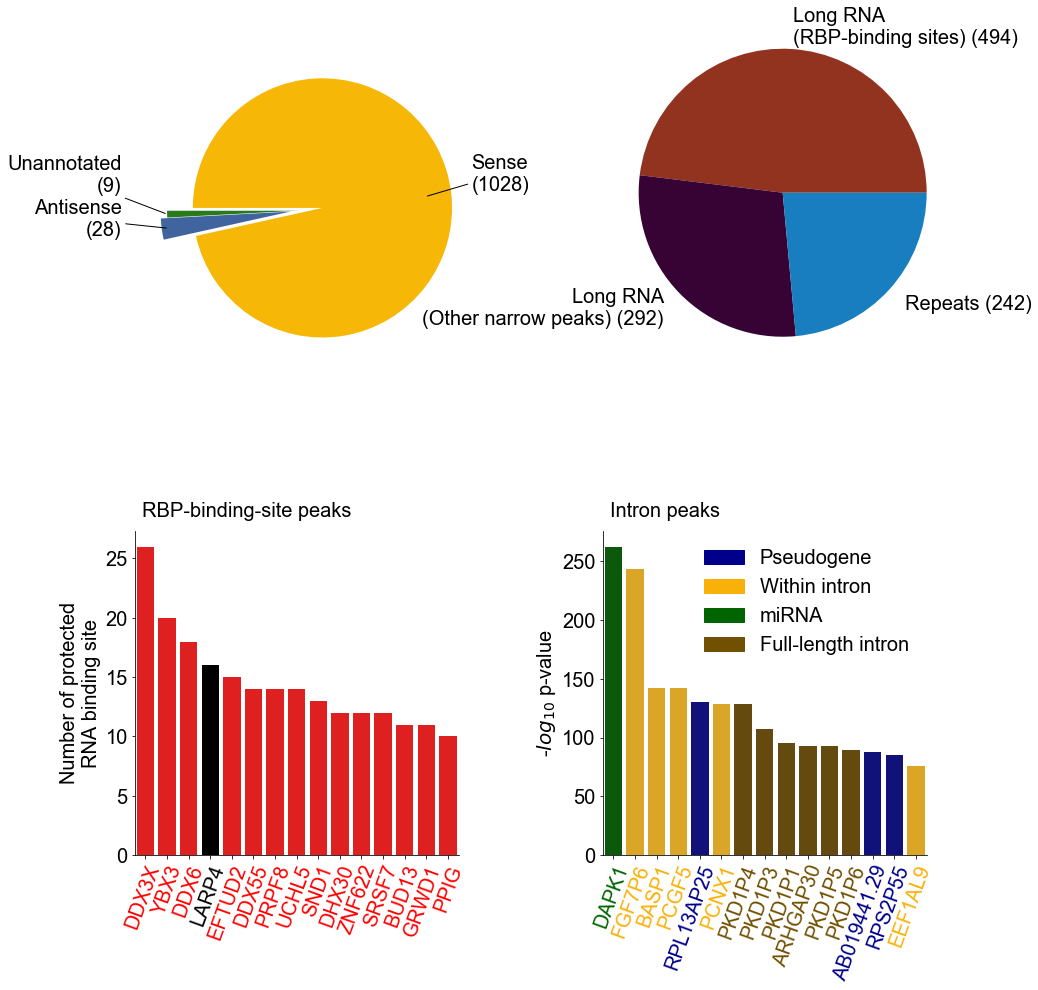

In [10]:
fig = plt.figure(figsize=(10,10))

strand_ax = fig.add_axes([-0.1, 0.52, 0.45, 0.45])
pie_ax = fig.add_axes([0.55, 0.52, 0.5, 0.5])
#rbp_ax = fig.add_axes([-0.1, 0, 0.35, 0.5])
#long_ax = fig.add_axes([0.38, 0, 0.35, 0.5])
rbp_ax = fig.add_axes([-0.1, -0.15, 0.45, 0.45])
long_ax = fig.add_axes([0.55, -0.15, 0.45, 0.45])

#misc_ax = fig.add_axes([0.84, 0, 0.35, 0.5])

top_n = 15
plot_peak_strand(peak_df, strand_ax)
sense_peaks = peak_df.query('is_sense == "Sense"')
plot_peak_pie(sense_peaks, pie_ax, ce)
#plot_repeats_RNA(sense_peaks, misc_ax, ce, rnatype='Repeats', top_n = top_n)
rbp_df = plot_rbp(sense_peaks, rbp_ax, ce, top_n = top_n)
plot_long_RNA_peak(exon_filtered_peaks, long_ax, ce, top_n = top_n, y_val = 'log10p')
used = set()
for xt in  long_ax.get_xticklabels():
    if xt.get_text() in {'AB019441.29','RPS2P55','RPL13AP25'}:
        rt = 'Pseudogene'
    elif xt.get_text() in 'DAPK1':
        rt = 'miRNA'
    elif re.search('PKD|ARHG',xt.get_text()):
        rt = 'Full-length intron'
    else:
        rt = 'Within intron'
    xt.set_color(peak_type_ce.encoder[rt])
    used.add(rt)
cc_ce = color_encoder()
cc_ce.encoder = {k:v for k,v in peak_type_ce.encoder.items() if k in used}
cc_ce.show_legend(ax = long_ax, frameon=False, fontsize=20)
sns.despine()



fig.text(-0.09,0.32, 'RBP-binding-site peaks', fontsize=20)
fig.text(0.56,0.32, 'Intron peaks', fontsize=20)
#fig.text(0.85,0.5, 'Repeats', fontsize=18)

figure_name = figure_path + '/peak_figure.pdf'
fig.savefig(figure_name, bbox_inches = 'tight')
print('Saved:', figure_name)

In [11]:
exon_filtered_peaks\
    .query('sense_gtype=="Long RNA"')\
    .sort_values('log10p', ascending=False)\
    .filter(['chrom','start','end','sense_gname','peakname'])\
    .head(20)

,chrom,start,end,sense_gname,peakname
21,chr9,90294212,90294292,DAPK1,unfragmented.filtered.fwd_peak_30031
23,chr9,46727655,46727777,RP11-111F5.5,unfragmented.filtered.fwd_peak_29822
49,chr10,92933895,92933968,PCGF5,unfragmented.filtered.fwd_peak_3913
50,chr5,17249702,17249764,BASP1,unfragmented.filtered.fwd_peak_23119
54,chr13,55014810,55015136,RP11-365K22.1,unfragmented.filtered.rvs_peak_7404
56,chr14,71389030,71389208,PCNX1,unfragmented.filtered.fwd_peak_8862
48,chr16,16468913,16469003,RP11-958N24.2,unfragmented.filtered.fwd_peak_10653
52,chr16,18430617,18430707,RP11-1212A22.1,unfragmented.filtered.rvs_peak_10040
59,chr16,15027133,15027223,RP11-958N24.1,unfragmented.filtered.fwd_peak_10632
76,chr14,71461625,71461751,PCNX1,unfragmented.filtered.fwd_peak_8864


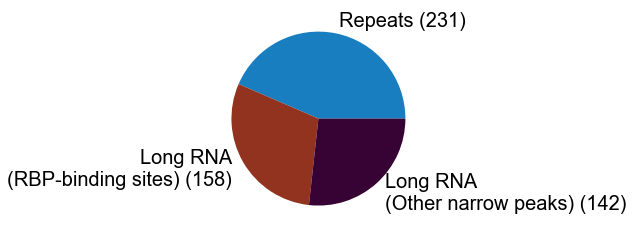

In [12]:
ax = plt.subplot()
sense_peaks = exon_filtered_peaks.query('is_sense == "Sense"')
plot_peak_pie(sense_peaks, ax, ce)

No handles with labels found to put in legend.


KeyError: 'Within introns'

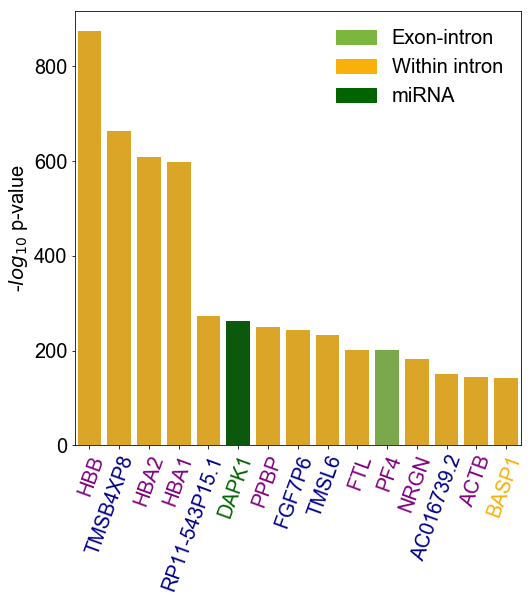

In [13]:
fig = plt.figure(figsize=(8,8))

#strand_ax = fig.add_axes([-0.1, 0.52, 0.45, 0.45])
#pie_ax = fig.add_axes([0.55, 0.52, 0.5, 0.5])
#rbp_ax = fig.add_axes([-0.1, 0, 0.35, 0.5])
#long_ax = fig.add_axes([0.38, 0, 0.35, 0.5])
#rbp_ax = fig.add_axes([-0.1, -0.15, 0.45, 0.45])
long_ax = fig.add_subplot(111)#fig.add_axes([0.55, -0.15, 0.45, 0.45])

#misc_ax = fig.add_axes([0.84, 0, 0.35, 0.5])

top_n = 15
#plot_peak_strand(exon_filtered_peaks, strand_ax)
sense_peaks = exon_filtered_peaks.query('is_sense == "Sense"')
#plot_peak_pie(exon_filtered_peaks, pie_ax, ce)
#plot_repeats_RNA(sense_peaks, misc_ax, ce, rnatype='Repeats', top_n = top_n)
#rbp_df = plot_rbp(exon_filtered_peaks, rbp_ax, ce, top_n = top_n)
plot_long_RNA_peak(peak_df, long_ax, ce, top_n = top_n, y_val = 'log10p')
used=set()
for xt in  long_ax.get_xticklabels():
    if xt.get_text() in {'HBB','HBA2','HBA1','PPBP','PF4','FTL','NRGN','ACTB'}:
        rt = 'mRNA'
    elif xt.get_text() in {'TMSB4XP8','TMSL6','AC016739.2','RP11-543P15.1',
                          'RP11-3P17.3','FGF7P6','RPL13AP25'}:
        rt = 'Pseudogene'
    elif xt.get_text() in 'DAPK1':
        rt='miRNA'    
    else:
        rt = 'Within introns'
    xt.set_color(peak_type_ce.encoder[rt])
    used.add(rt)
cc_ce = color_encoder()
cc_ce.encoder = {k:v for k,v in peak_type_ce.encoder.items() if k in used}
cc_ce.show_legend(ax = long_ax, frameon=False, fontsize=20)
sns.despine()

figure_name = figure_path + '/peak_figure_filtered.pdf'
fig.savefig(figure_name, bbox_inches = 'tight')
print('Saved:', figure_name)